In [ ]:
#%pip install torchvision

In [9]:

#%pip install --upgrade segments-ai
#%pip install -q transformers datasets segments-ai evaluate

In [1]:
import matplotlib.pyplot as plt
from segments.utils import get_semantic_bitmap
from segments import SegmentsClient
from segments.huggingface import release2dataset
from datasets import load_dataset

In [ ]:


#your segments.ai api key
api_key = "your_api_key"
from huggingface_hub import notebook_login

client = SegmentsClient(api_key)

I created a cloned dataset of only the labeled chargers, I think there was an issue with the other ones

In [3]:
dataset_identifier = "dskong07/chargers-full"
name = "chargers-labeled-full-v0.1"

In [4]:
client.add_release(dataset_identifier, name)
#uncomment if ur making a new release, i already made one so should be okay

Release(uuid='6711b916-3e1c-454a-801c-a576952838c9', name='chargers-labeled-full-v0.1', description='', release_type='JSON', attributes=URL(url='', signed_url=None), status='PENDING', created_at='2025-02-23T21:14:38.777101Z', samples_count=167)

In [5]:
notebook_login()

In [6]:

release_name = "chargers-labeled-full-v0.1"


release = client.get_release(dataset_identifier, release_name)
hf_dataset = release2dataset(release)

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Aloha+Charge+ChargePoint+CT4000+Family+of+Charging+Stations.jpg


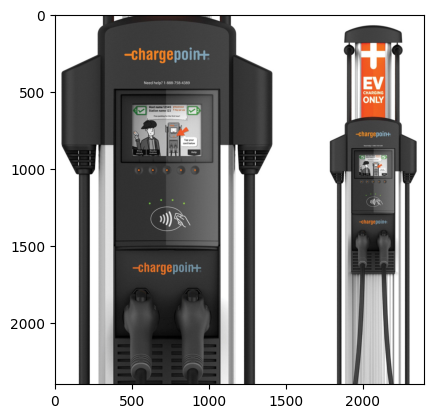

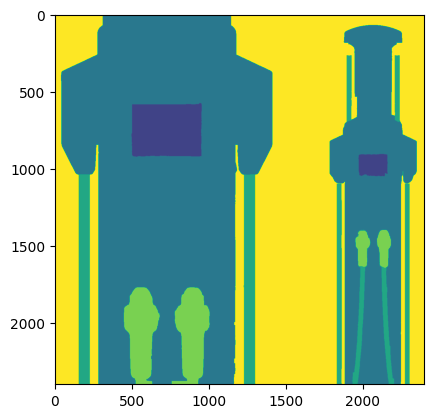

charger.jpg


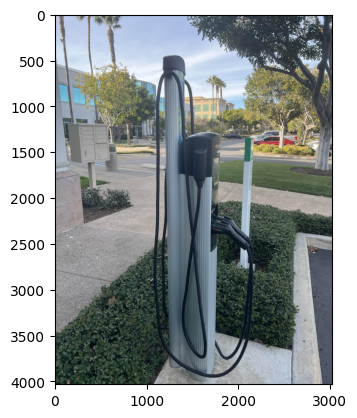

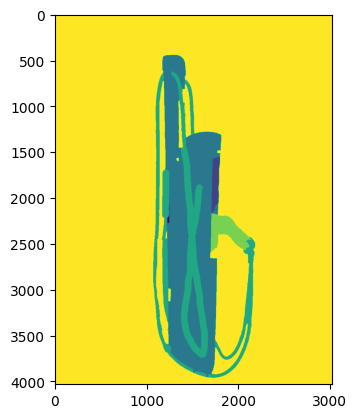

1262357.jpg


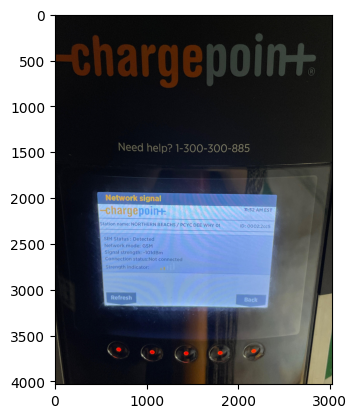

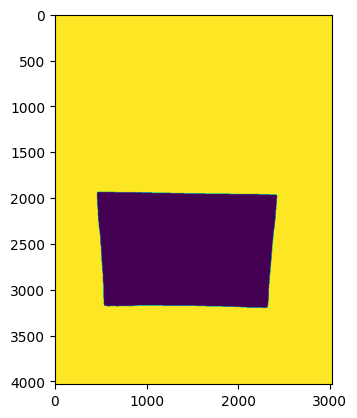

images.jpg


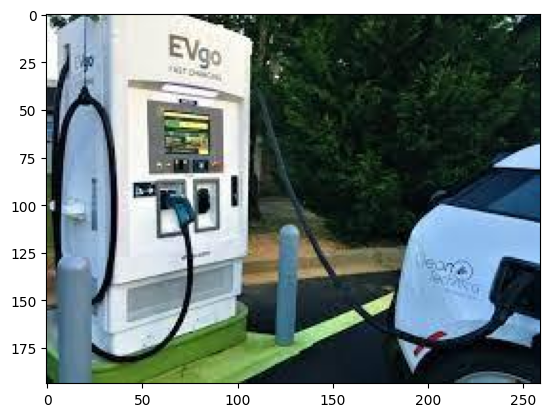

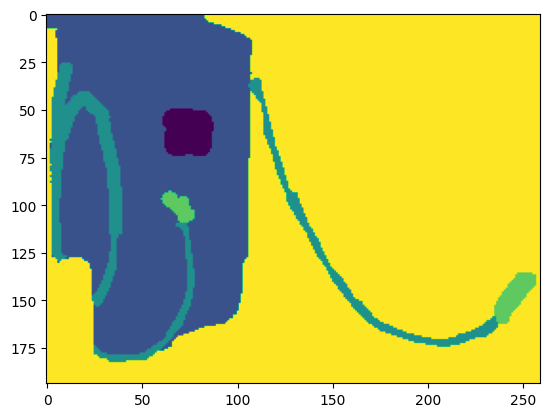

PG07_EVGO_0423-EVgo-charging-station-weho-1.jpg


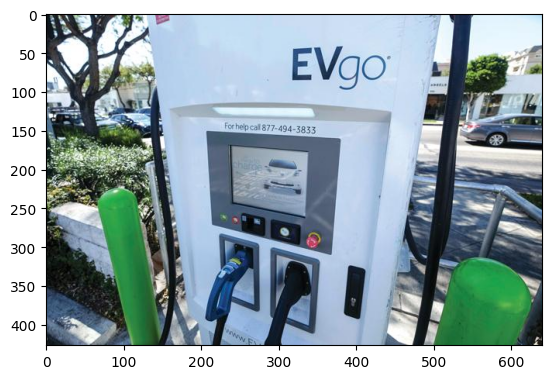

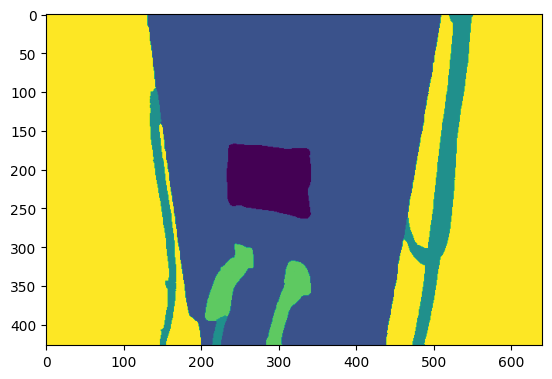

In [7]:


ct = 0
for sample in hf_dataset:
    ct += 1

    print(sample['name'])

    # Show the image
    plt.imshow(sample['image'])
    plt.show()

    # Show the semantic segmentation label
    semantic_bitmap = get_semantic_bitmap(sample['label.segmentation_bitmap'], sample['label.annotations'])
    plt.imshow(semantic_bitmap)
    plt.show()
    
    if (ct == 5):
        break

In [8]:


def convert_segmentation_bitmap(example):
    return {
        "label.segmentation_bitmap":
            get_semantic_bitmap(
                example["label.segmentation_bitmap"],
                example["label.annotations"],
            )
    }


semantic_dataset = hf_dataset.map(
    convert_segmentation_bitmap,
)

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

In [9]:
semantic_dataset = semantic_dataset.rename_column('image', 'pixel_values')
semantic_dataset = semantic_dataset.rename_column('label.segmentation_bitmap', 'label')
semantic_dataset = semantic_dataset.remove_columns(['name', 'uuid', 'status', 'label.annotations'])

In [10]:
hf_dataset_identifier = f"dskong07/chargers-full-v0.1"

semantic_dataset.push_to_hub(hf_dataset_identifier)

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Now getting the uploaded dataset, and doing stuff

In [11]:
from datasets import load_dataset

ds = load_dataset(hf_dataset_identifier)

README.md:   0%|          | 0.00/324 [00:00<?, ?B/s]

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dskon\.cache\huggingface\hub\datasets--dskong07--chargers-full-v0.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00003.parquet:   0%|          | 0.00/46.5M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/29.5M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

In [12]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
import json
from huggingface_hub import hf_hub_download

repo_id = f"datasets/{hf_dataset_identifier}"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))

# for some reason this isn't working, not sure where i messed up, but i'll just make a custom id2label json

In [13]:
id2label = {0: 'unlabeled', 1: 'screen', 2: 'body', 3: 'cable', 4: 'plug', 5: 'void-background'}
label2id = {v: k for k, v in id2label.items()}


In [14]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear

In [15]:
from torchvision.transforms import ColorJitter
from transformers import (
    SegformerImageProcessor,
)

processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-chargers-2-15"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-chargers-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
import torch
from torch import nn
import evaluate
import multiprocessing

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [18]:
train_ds[0]

{'pixel_values': array([[[-0.6622999 , -0.7650484 , -1.004795  , ...,  0.5535577 ,
           0.5535577 ,  0.5535577 ],
         [-0.7650484 , -0.81642264, -0.95342064, ...,  0.5535577 ,
           0.5535577 ,  0.5535577 ],
         [-0.81642264, -0.81642264, -0.9705454 , ...,  0.5535577 ,
           0.5535577 ,  0.5535577 ],
         ...,
         [-1.0561693 , -1.0219197 , -1.0561693 , ...,  0.14256364,
          -0.30268008, -0.8506721 ],
         [-1.0561693 , -1.0390445 , -1.0390445 , ...,  0.14256364,
           0.02269024, -0.67942464],
         [-1.0390445 , -1.0561693 , -1.0561693 , ...,  0.10831413,
           0.15968838, -0.43967807]],
 
        [[-0.495098  , -0.495098  , -0.00490195, ...,  0.71288526,
           0.71288526,  0.7303922 ],
         [-0.60014   , -0.547619  ,  0.06512605, ...,  0.69537824,
           0.71288526,  0.7303922 ],
         [-0.65266097, -0.565126  ,  0.04761905, ...,  0.71288526,
           0.71288526,  0.71288526],
         ...,
         [-0.8802

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: dskong07 (dskong07-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


C:\Users\dskon\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
C:\Users\dskon\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
C:\Users\dskon\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
C:\Users\dskon\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: 

TrainOutput(global_step=3350, training_loss=0.24514956423706974, metrics={'train_runtime': 5229.604, 'train_samples_per_second': 1.272, 'train_steps_per_second': 0.641, 'total_flos': 1.165931614568448e+17, 'train_loss': 0.24514956423706974, 'epoch': 50.0})

In [24]:
hub_model_id = "segformer-b0-finetuned-segments-chargers-2-15"
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

processor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

README.md:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/dskong07/segformer-b0-finetuned-segments-chargers-2-15/commit/56fae6fbc7fdaf58ca84f3475fb44adabaac1001', commit_message='End of training', commit_description='', oid='56fae6fbc7fdaf58ca84f3475fb44adabaac1001', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dskong07/segformer-b0-finetuned-segments-chargers-2-15', endpoint='https://huggingface.co', repo_type='model', repo_id='dskong07/segformer-b0-finetuned-segments-chargers-2-15'), pr_revision=None, pr_num=None)

Can interact with inference via the HF hub: https://huggingface.co/docs/api-inference/index

In [25]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

processor = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained(f"{'dskong07'}/{hub_model_id}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

In [26]:
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['labels']
image.shape, gt_seg.shape

((3, 512, 512), (512, 512))

In [27]:
import numpy as np

def normalize(data):
    return (data-np.min(data))/(np.max(data)-np.min(data)) 
new_image = normalize(image)
image.shape, new_image.shape

((3, 512, 512), (3, 512, 512))

In [ ]:
"""
from torch import nn

inputs = processor(images=new_image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.shape[::-1], # (height, width)
    #scale_factor=1,
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]
"""

In [29]:
palette = [
    [0, 0, 0],  # unlabeled
    [216, 0, 24], 
    [255, 255, 0],  
    [125, 46, 141], 
    [118, 171, 47], 
    [125, 0, 225]
]

In [36]:
import numpy as np

def get_seg_overlay(image, seg):
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
  palette = np.array(palette)
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color

  # Show image + mask
  img = np.array(image) * 0.5 + color_seg * 0.5
  img = img.astype(np.uint8)

  return img

In [33]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

palette = [
    [0, 0, 0],  # unlabeled
    [216, 0, 24], 
    [255, 255, 0],  
    [125, 46, 141], 
    [118, 171, 47], 
    [125, 0, 225]
]

def get_overlays(path, is_web = True):

    #url = "https://media.wired.com/photos/6650c3c556be637959104b4c/master/w_2240,c_limit/How-Many-EV-Chargers-Do-We-Need--Gear-GettyImages-1242853407.jpg"
    if is_web:
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)

    image_segmentator = pipeline(
        "image-segmentation",
        model=f"{'dskong07'}/{hub_model_id}",  # Change with your model name
    )
    results = image_segmentator(image)


    image_array = np.array(image)

    segmentation_map = np.zeros_like(image_array)

    for result in results:

        mask = np.array(result["mask"])

        label = result["label"]

        label_index = list(id2label.values()).index(label)

        color = palette[label_index]

        for c in range(3):

            segmentation_map[:, :, c] = np.where(mask, color[c], segmentation_map[:, :, c])
    return image, image_array, segmentation_map



preprocessor_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


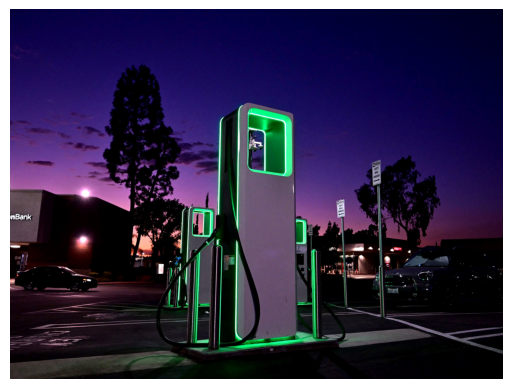

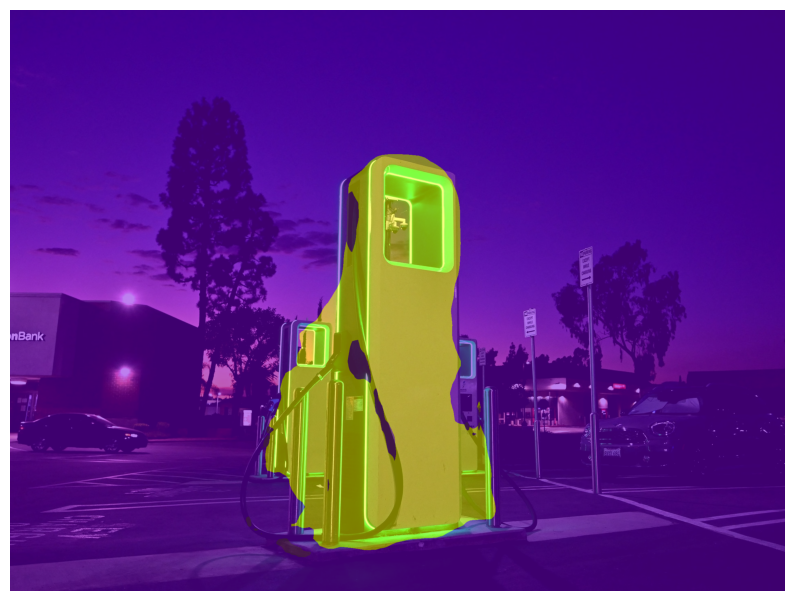

In [34]:
url = 'https://media.wired.com/photos/6650c3c556be637959104b4c/master/w_2240,c_limit/How-Many-EV-Chargers-Do-We-Need--Gear-GettyImages-1242853407.jpg'
image, image_array, segmentation_map = get_overlays(url)

plt.imshow(image)

plt.axis("off")

plt.show()
plt.figure(figsize=(10, 10))

plt.imshow(image_array)

plt.imshow(segmentation_map, alpha=0.5)

plt.axis("off")

plt.show()

Device set to use cpu


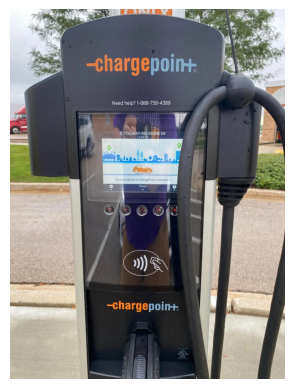

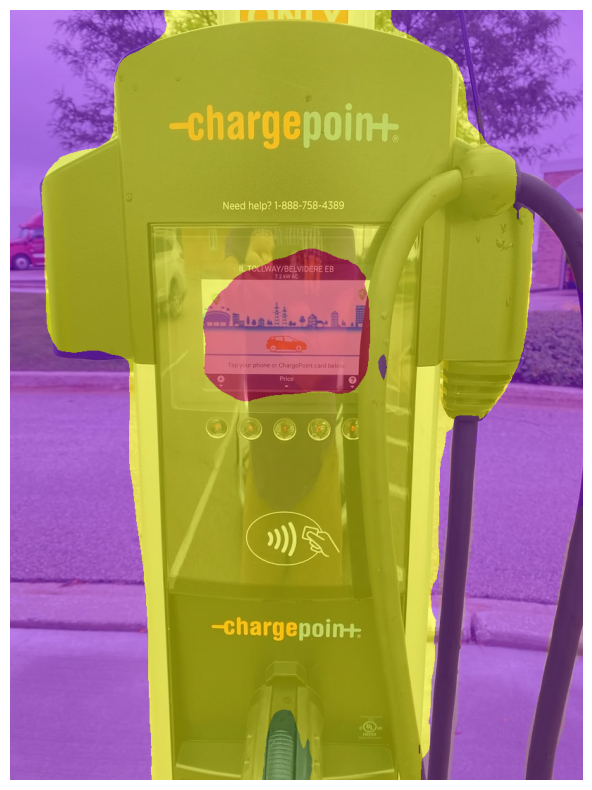

In [129]:
path = 'example.jpg'
image, image_array, segmentation_map = get_overlays(path, is_web = False)

plt.imshow(image)

plt.axis("off")

plt.show()
plt.figure(figsize=(10, 10))

plt.imshow(image_array)

plt.imshow(segmentation_map, alpha=0.5)

plt.axis("off")

plt.show()

Device set to use cpu


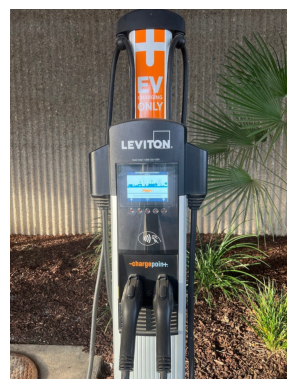

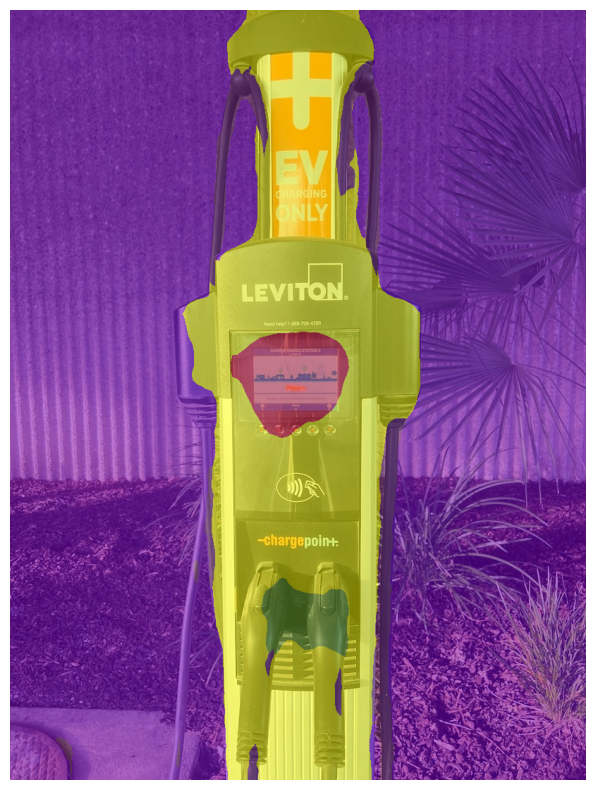

In [35]:
path = 'example2.jpg'
image, image_array, segmentation_map = get_overlays(path, is_web = False)

plt.imshow(image)

plt.axis("off")

plt.show()
plt.figure(figsize=(10, 10))

plt.imshow(image_array)

plt.imshow(segmentation_map, alpha=0.5)

plt.axis("off")

plt.show()